<a href="https://colab.research.google.com/github/Latamila/ConsumoEnergiaSerieTemporal/blob/main/ConsumoEnergia4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.10.12


In [ ]:
!pip install -q -U watermark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 5.0 MB/s eta 0:00:00


In [ ]:
# Imports para manipulação de dados
import numpy as np
import pandas as pd

# Imports para visualização de dados
import matplotlib.pyplot as plt
import matplotlib as m
import seaborn as sns

# Imports para análise de dados
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [ ]:
# Imports para formatação dos gráficos
from pylab import rcParams
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 18, 8
plt.style.use('fivethirtyeight')

In [ ]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

matplotlib : 3.7.1
statsmodels: 0.14.0
pandas     : 1.5.3
seaborn    : 0.12.2
numpy      : 1.23.5



In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset.csv to dataset.csv


In [ ]:
# Carrega os dados
# Observe que estamos carregando os dados e já definindo a data como índice com o parâmetro index_col = 0
dados_serie = pd.read_csv('dataset.csv',
                          header = None,
                          index_col = 0,
                          names = ['consumo_energia'])

In [ ]:
dados_serie.head()

,consumo_energia
2004-01,112
2004-02,118
2004-03,132
2004-04,129
2004-05,121


## Suavização Através da Média Móvel Simples

- Calculamos a média de valores 'k' consecutivos, dependendo da frequência da série temporal.
- Aqui podemos calcular a média do último 1 ano, ou seja, os últimos 12 valores.
- Uma desvantagem dessa abordagem específica é que o período de tempo deve ser estritamente definido.

In [ ]:
# Primeiro, vamos calcular a média da série (essa não é a média móvel, mas sim a média total)
dados_serie.mean()

consumo_energia    280.3125
dtype: float64

In [ ]:
# Vamos criar uma cópia da série original pois isso será importante mais tarde
df_serie = dados_serie.copy()

In [ ]:
# Agora definimos uma janela de 12 meses da série temporal para calcular a média móvel
# Vamos gravar o resultado em outra coluna no próprio dataset
dados_serie['consumo_energia_serie_suavizada'] = dados_serie.rolling(window = 12).mean()

In [ ]:
dados_serie

,consumo_energia,consumo_energia_serie_suavizada
2004-01,112,NaN
2004-02,118,NaN
2004-03,132,NaN
2004-04,129,NaN
2004-05,121,NaN
...,...,...
2015-08,606,463.333333
2015-09,508,467.083333
2015-10,461,471.583333
2015-11,390,473.916667


Agora temos duas colunas e alguns valores NaN na coluna das médias móveis. Isso é normal e esperado, afinal, calculamos a média de 12 valores consecutivos "deslizando" a janela pela série e para alguns valores (os primeiros da série) não teremos como calcular a média dos 12 valores anteriores e assim eles ficam como NaN. Ou seja, perdemos registros da série ao aplicar esta técnica de suavização.

In [ ]:
# Primeiros 20 registros da série
dados_serie.head(20)

,consumo_energia,consumo_energia_serie_suavizada
2004-01,112,NaN
2004-02,118,NaN
2004-03,132,NaN
2004-04,129,NaN
2004-05,121,NaN
2004-06,135,NaN
2004-07,148,NaN
2004-08,148,NaN
2004-09,136,NaN
2004-10,119,NaN


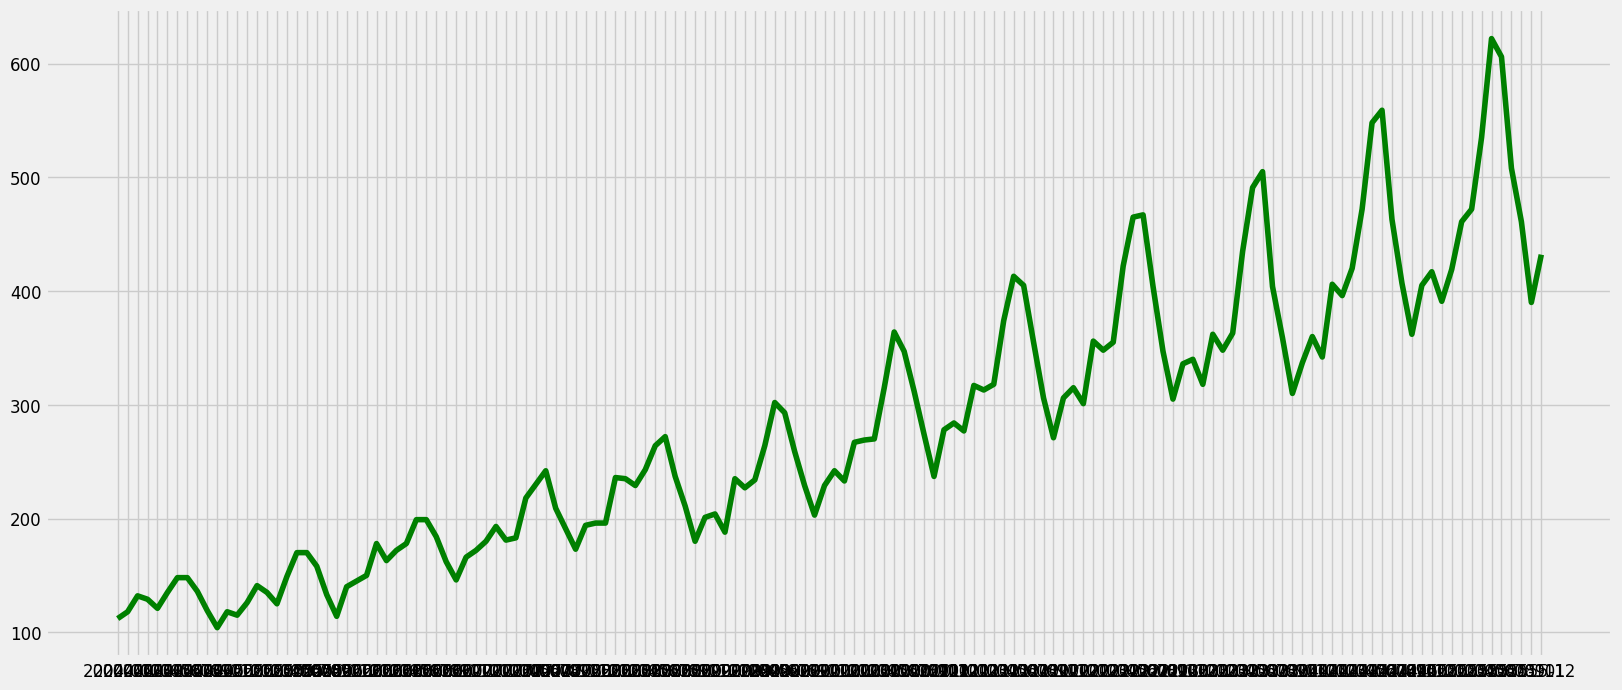

In [ ]:
# Plot da série original
plt.plot(dados_serie['consumo_energia'], color = 'green')

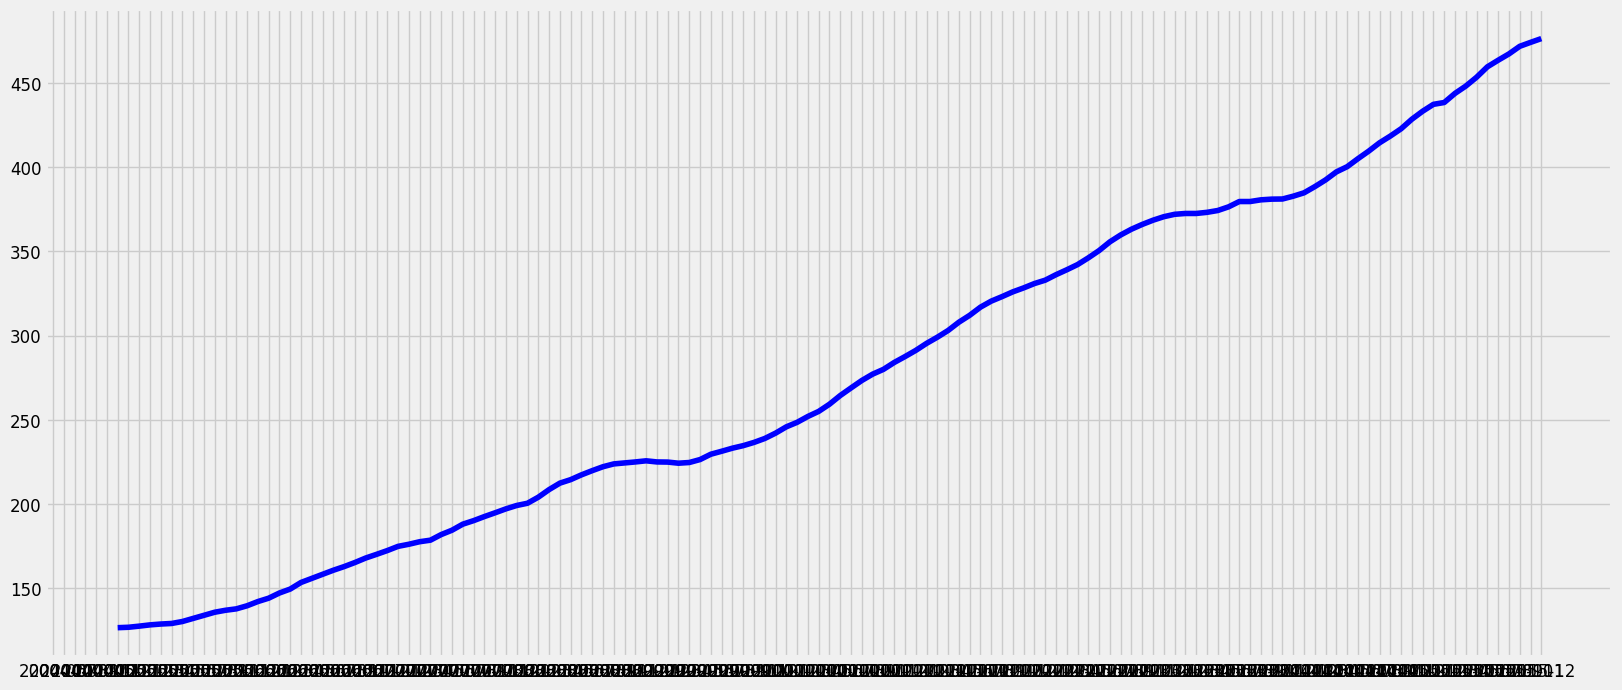

In [ ]:
# Plot da série suavizada
plt.plot(dados_serie['consumo_energia_serie_suavizada'], color = 'blue')

A diferença é grande, não é? Vamos colocar as duas juntas agora.

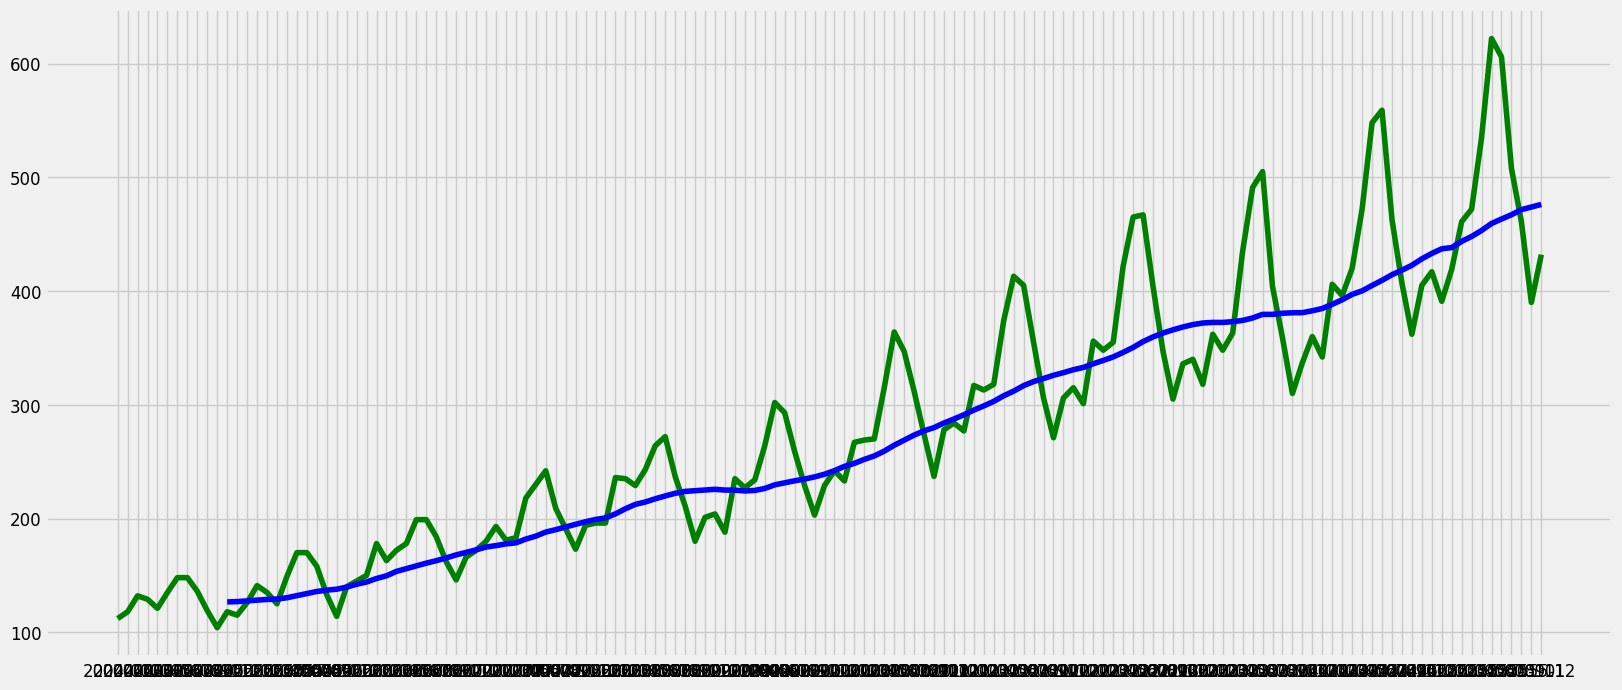

In [ ]:
# Agora as duas juntas
plt.plot(dados_serie['consumo_energia'], color = 'green')
plt.plot(dados_serie['consumo_energia_serie_suavizada'], color = 'blue')

In [ ]:
# Calculando a diferença entre a série original e a série suavizada
# Aqui estamos removendo a tendência da série original e deixando apenas a sazonalidade
diff_original_suavizada = dados_serie['consumo_energia'] - dados_serie['consumo_energia_serie_suavizada']
diff_original_suavizada.head(20)

2004-01          NaN
2004-02          NaN
2004-03          NaN
2004-04          NaN
2004-05          NaN
2004-06          NaN
2004-07          NaN
2004-08          NaN
2004-09          NaN
2004-10          NaN
2004-11          NaN
2004-12    -8.666667
2005-01   -11.916667
2005-02    -1.583333
2005-03    12.666667
2005-04     6.166667
2005-05    -4.166667
2005-06    18.666667
2005-07    37.833333
2005-08    36.000000
dtype: float64

In [ ]:
# Vamos remover os valores NA para testar a estacionaridade
diff_original_suavizada.dropna(inplace = True)

In [ ]:
# Função para testar a estacionaridade
def testa_estacionaridade(serie):

    # Calcula estatísticas móveis
    rolmean = serie.rolling(window = 12).mean()
    rolstd = serie.rolling(window = 12).std()

    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média Móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio Padrão')

    # Plot
    plt.legend(loc = 'best')
    plt.title('Estatísticas Móveis - Média e Desvio Padrão')
    plt.show()

    # Teste Dickey-Fuller:
    # Print
    print('\nResultado do Teste Dickey-Fuller:\n')

    # Teste
    dfteste = adfuller(serie, autolag = 'AIC')

    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatística do Teste',
                                               'Valor-p',
                                               'Número de Lags Consideradas',
                                               'Número de Observações Usadas'])

    # Loop por cada item da saída do teste
    for key, value in dfteste[4].items():
        dfsaida['Valor Crítico (%s)'%key] = value

    # Print
    print (dfsaida)

    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')

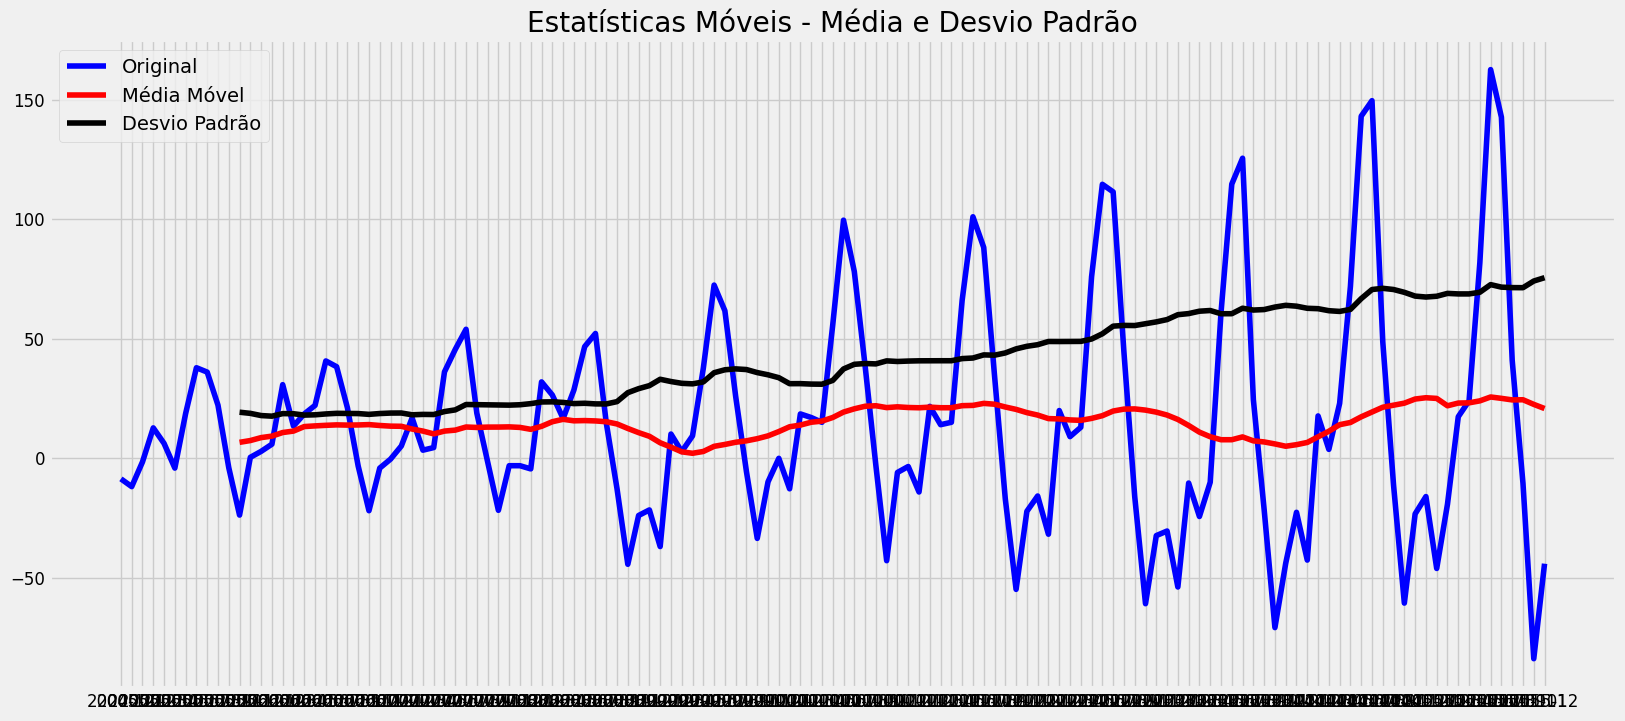


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -3.157851
Valor-p                           0.022558
Número de Lags Consideradas      13.000000
Número de Observações Usadas    119.000000
Valor Crítico (1%)               -3.486535
Valor Crítico (5%)               -2.886151
Valor Crítico (10%)              -2.579896
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [ ]:
# Executando o teste de estacionaridade
testa_estacionaridade(diff_original_suavizada)

Aplicamos a suavização e extraímos a tendência da série. Esta série foi transformada e já poderíamos usá-la para modelagem estatística. Mas temos um problema. Perdemos uma parte dos dados, parte essa que poderia ser importante para prever o comportamento futuro.

Vamos testar outra técnica de suavização e verificar se temos sucesso sem perder tantos dados.

### Suavização Através da Média Móvel Ponderada Exponencial

- Para superar o problema de escolher uma janela definida na média móvel, podemos usar a média móvel ponderada exponencial.
- Adotamos uma "média móvel ponderada", em que valores mais recentes recebem um peso maior.
- Pode haver muitas técnicas para atribuir pesos. Uma popular é a média móvel ponderada exponencialmente em que os pesos são atribuídos a todos os valores anteriores com um fator de redução.

A função ewm() do Pandas permite aplicar esse método com facilidade.

In [ ]:
# Aplicando suavização exponencial
# Observe que estamos aplicando a suavização à série original (antes de aplicar a suavização anterior)
serie_suavizada_exp = df_serie.ewm(alpha = 0.2, adjust = True).mean()

In [ ]:
serie_suavizada_exp


,consumo_energia
2004-01,112.000000
2004-02,115.333333
2004-03,122.163934
2004-04,124.479675
2004-05,123.444550
...,...
2015-08,512.214093
2015-09,511.371274
2015-10,501.297019
2015-11,479.037615


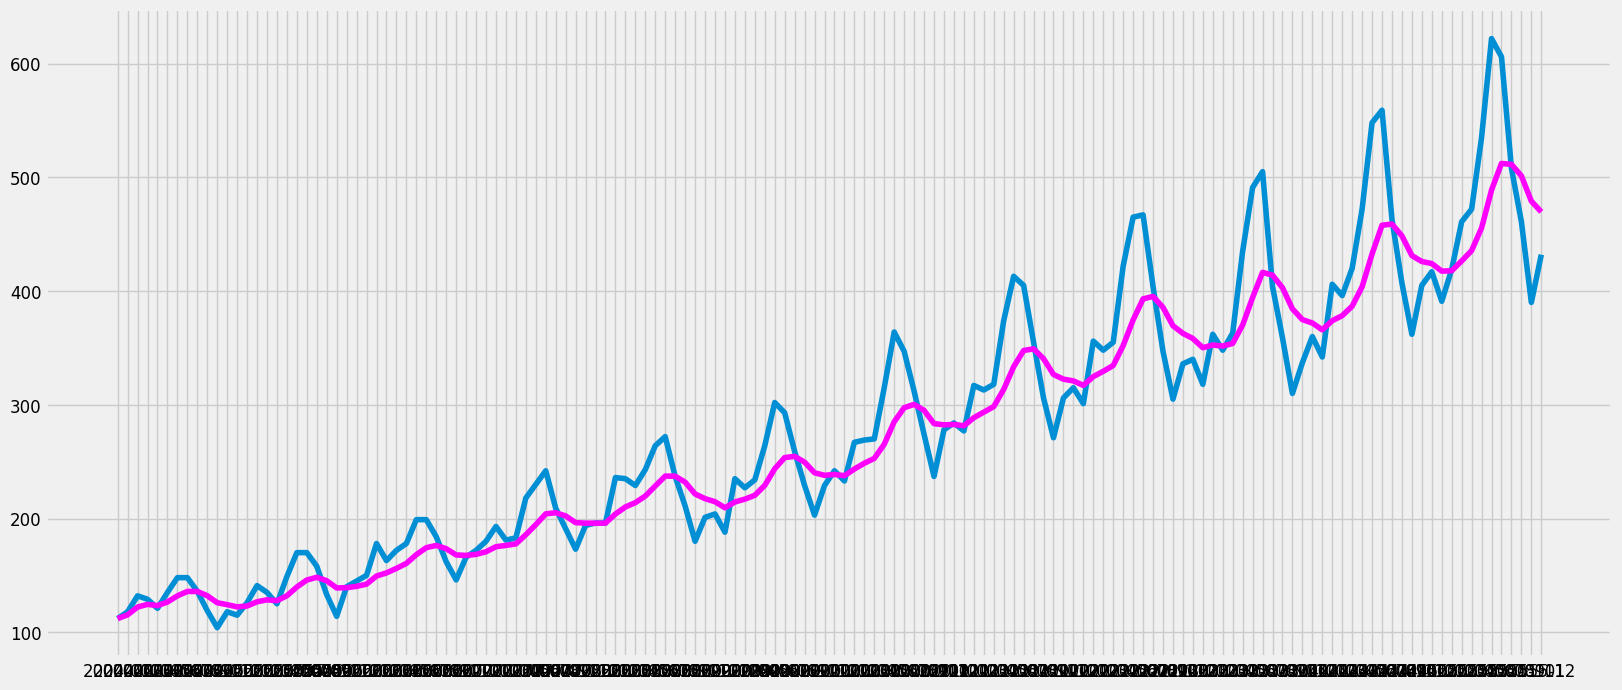

In [ ]:
# Plt das séries
plt.plot(df_serie)
plt.plot(serie_suavizada_exp, color = 'magenta')

Suavização aplicada. Vamos agora calcular a diferença e aplicar o teste de estacionaridade.

In [ ]:
# Diferença
diff_original_suav_exp = df_serie.consumo_energia - serie_suavizada_exp.consumo_energia

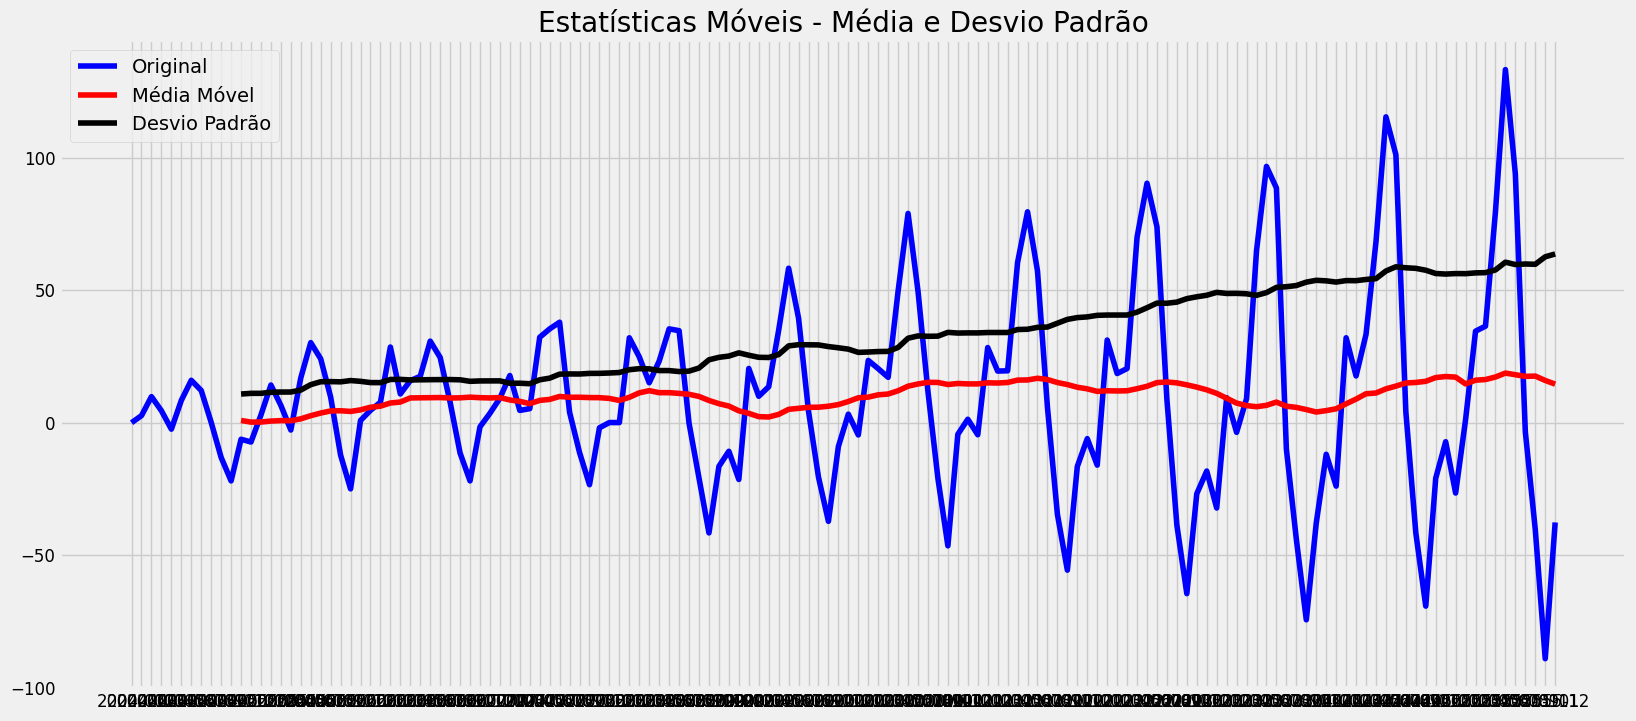


Resultado do Teste Dickey-Fuller:

Estatística do Teste             -2.795521
Valor-p                           0.058916
Número de Lags Consideradas      13.000000
Número de Observações Usadas    130.000000
Valor Crítico (1%)               -3.481682
Valor Crítico (5%)               -2.884042
Valor Crítico (10%)              -2.578770
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [ ]:
# Executando o teste de estacionaridade
testa_estacionaridade(diff_original_suav_exp)

Perceba que a Suavização Exponencial não foi suficiente para deixar a série estacionária.

**Com a suavização podemos transformar nossa série em estacionária. Mas essas técnicas simples de suavização não funcionam em todos os casos, principalmente nos de alta sazonalidade. E para esses casos precisamos da Diferenciação, tema da próxima aula.**

### FIM DA PARTE 4